# Sentiment Analysis in IMDB 

## Import Dataset
The IMDB movie dataset contains reviews along with labels either be positive (1) or negative (0). The training set and test set can be easily downloaded through tensorflow_datasets package.

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import io
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'2.0.0'

In [3]:
imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

In [4]:
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=0.1.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    urls=['http://ai.stanford.edu/~amaas/data/sentiment/'],
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
      title     = {Learning Word V

In [5]:
train, test = imdb['train'], imdb['test']

In [6]:
train_sentences = []
train_labels = []
test_sentences = []
test_labels = []

# s and l are stored in tensor format
# thus, we can get their values using numpy() method
for s, l in train:
    train_sentences.append(str(s.numpy()))
    train_labels.append(l.numpy())
    
for s,l in test:
    test_sentences.append(str(s.numpy()))
    test_labels.append(l.numpy())

In [7]:
train_labels[:5]

[1, 1, 1, 1, 1]

In [8]:
# we need labels to be np.array format
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

## Tokenize & Pad Text Data

In [9]:
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_sentences)
wordIndex = tokenizer.word_index
train_seq = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_seq, maxlen=150, truncating='post')

test_seq = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_seq, maxlen=150, truncating='post')

In [10]:
print(train_padded.shape)
print(test_padded.shape)

(25000, 150)
(25000, 150)


## Build Initial Model

In [11]:
mod = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=150),
    tf.keras.layers.GlobalAvgPool1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

mod.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

mod.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 102       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 160,109
Trainable params: 160,109
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = mod.fit(train_padded,
                  train_labels,
                  epochs=10,
                  validation_data=(test_padded, test_labels),
                  verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 - 6s - loss: 0.5399 - accuracy: 0.7617 - val_loss: 0.3919 - val_accuracy: 0.8342
Epoch 2/10
25000/25000 - 4s - loss: 0.3153 - accuracy: 0.8713 - val_loss: 0.3464 - val_accuracy: 0.8483
Epoch 3/10
25000/25000 - 4s - loss: 0.2539 - accuracy: 0.8995 - val_loss: 0.3456 - val_accuracy: 0.8498
Epoch 4/10
25000/25000 - 5s - loss: 0.2194 - accuracy: 0.9155 - val_loss: 0.3657 - val_accuracy: 0.8445
Epoch 5/10
25000/25000 - 5s - loss: 0.1924 - accuracy: 0.9293 - val_loss: 0.3941 - val_accuracy: 0.8391
Epoch 6/10
25000/25000 - 5s - loss: 0.1715 - accuracy: 0.9383 - val_loss: 0.4146 - val_accuracy: 0.8356
Epoch 7/10
25000/25000 - 5s - loss: 0.1541 - accuracy: 0.9464 - val_loss: 0.4525 - val_accuracy: 0.8303
Epoch 8/10
25000/25000 - 4s - loss: 0.1385 - accuracy: 0.9534 - val_loss: 0.4912 - val_accuracy: 0.8269
Epoch 9/10
25000/25000 - 4s - loss: 0.1253 - accuracy: 0.9589 - val_loss: 0.5273 - val_accuracy: 0.8241
Epoch 10/10
25

## Visualize Word Embedding

In [13]:
e = mod.layers[0]
weights = e.get_weights()[0]
weights.shape

(10000, 16)

In [14]:
rev_wordIndex = dict([(value, key) for (key, value) in wordIndex.items()])

In [15]:
# create meta data for tensorflow projector
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, 10000):
    word = rev_wordIndex[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

Go to https://projector.tensorflow.org/ and upload vecs.tsv and meta.tsv files to visualize the word embedding results. You will see the similar result as below.

<img src="wordEmbedding.jpg">

## Get Initial Result

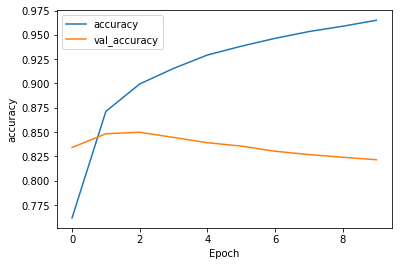

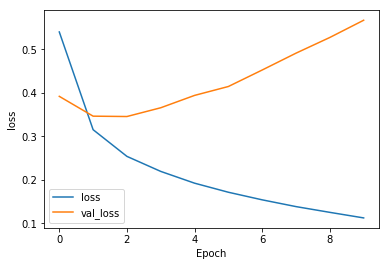

In [16]:
def plot(history, name):
    plt.plot(history.history[name])
    plt.plot(history.history['val_'+name])
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend([name, 'val_'+name])
    plt.show()

plot(history, 'accuracy')
plot(history, 'loss')

From the accuracy graph and loss graph above, we see that after the second epoch the training starts to be overfitting. Thus, we should try different hyperparameters or methods to improve the model.

## Add LSTM Layers

In [18]:
mod = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=150),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

mod.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

mod.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 150, 128)          41472     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 246,913
Trainable params: 246,913
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = mod.fit(train_padded,
                  train_labels,
                  epochs=10,
                  validation_data=(test_padded, test_labels),
                  verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 - 191s - loss: 0.4515 - accuracy: 0.7832 - val_loss: 0.3842 - val_accuracy: 0.8398
Epoch 2/10
25000/25000 - 188s - loss: 0.2852 - accuracy: 0.8883 - val_loss: 0.3892 - val_accuracy: 0.8357
Epoch 3/10
25000/25000 - 193s - loss: 0.2156 - accuracy: 0.9188 - val_loss: 0.4765 - val_accuracy: 0.8096
Epoch 4/10
25000/25000 - 194s - loss: 0.1571 - accuracy: 0.9426 - val_loss: 0.5355 - val_accuracy: 0.8143
Epoch 5/10
25000/25000 - 212s - loss: 0.1180 - accuracy: 0.9588 - val_loss: 0.6397 - val_accuracy: 0.8094
Epoch 6/10
25000/25000 - 209s - loss: 0.0852 - accuracy: 0.9710 - val_loss: 0.6369 - val_accuracy: 0.8123
Epoch 7/10
25000/25000 - 227s - loss: 0.0642 - accuracy: 0.9794 - val_loss: 0.6813 - val_accuracy: 0.7864
Epoch 8/10
25000/25000 - 224s - loss: 0.0639 - accuracy: 0.9788 - val_loss: 0.7599 - val_accuracy: 0.8040
Epoch 9/10
25000/25000 - 185s - loss: 0.0461 - accuracy: 0.9853 - val_loss: 1.0619 - val_accuracy: 0.8

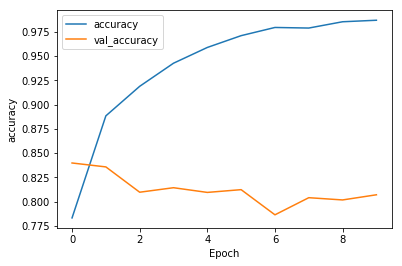

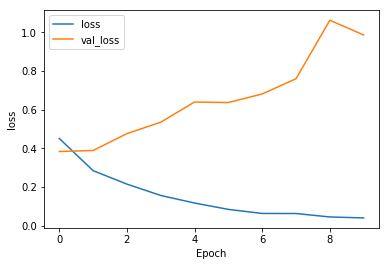

In [20]:
plot(history, 'accuracy')
plot(history, 'loss')

We see that using LSTM also has the overfitting problem. The training accuracy is higher than 97% but the validation accuracy is about 80%. Thus, we furthur need to seek a way to avoid overfitting in the model.